# 🏦 Loan Analysis Training Pipeline

https://www.kaggle.com/code/faressayah/lending-club-loan-defaulters-prediction 




In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc
)
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from yahoo_fin import stock_info as si
from collections import deque

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os

#gpus = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpus[0], True)
    
os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'

#policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
#tf.keras.mixed_precision.experimental.set_policy(policy) 

pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

## 🔖 Hopsworks Feature Store

In [2]:
import hopsworks

proj = hopsworks.login()
fs = proj.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/38123
Connected. Call `.close()` to terminate connection gracefully.


## Create the Feature View

In [45]:
fg_spy = fs.get_feature_group(name="historical_data", version=1)

query = fg_spy.select_except(["id"])

In [47]:
try:
    fv = fs.get_feature_view(name="historical_data", version=1)
except:
    fv = fs.create_feature_view(name="historical_data", 
                       version=1,
                        description="Historical Data",
                        labels=["close_4","high_4","low_4","open_4"],
                        query=query
                       )

In [48]:
start_time = time.time()

X_train, X_test, y_train, y_test = fv.train_test_split(test_size=0.2)

print("Get Random Split Training Data in %s seconds ---" % (time.time() - start_time))

2023-05-01 13:06:29,672 INFO: USE `workshop_featurestore`
2023-05-01 13:06:30,094 INFO: SELECT `fg0`.`close_0` `close_0`, `fg0`.`ema_0` `ema_0`, `fg0`.`high_0` `high_0`, `fg0`.`low_0` `low_0`, `fg0`.`open_0` `open_0`, `fg0`.`rsi_0` `rsi_0`, `fg0`.`sma_0` `sma_0`, `fg0`.`volume_0` `volume_0`, `fg0`.`close_1` `close_1`, `fg0`.`ema_1` `ema_1`, `fg0`.`high_1` `high_1`, `fg0`.`low_1` `low_1`, `fg0`.`open_1` `open_1`, `fg0`.`rsi_1` `rsi_1`, `fg0`.`sma_1` `sma_1`, `fg0`.`volume_1` `volume_1`, `fg0`.`close_2` `close_2`, `fg0`.`ema_2` `ema_2`, `fg0`.`high_2` `high_2`, `fg0`.`low_2` `low_2`, `fg0`.`open_2` `open_2`, `fg0`.`rsi_2` `rsi_2`, `fg0`.`sma_2` `sma_2`, `fg0`.`volume_2` `volume_2`, `fg0`.`close_3` `close_3`, `fg0`.`ema_3` `ema_3`, `fg0`.`high_3` `high_3`, `fg0`.`low_3` `low_3`, `fg0`.`open_3` `open_3`, `fg0`.`rsi_3` `rsi_3`, `fg0`.`sma_3` `sma_3`, `fg0`.`volume_3` `volume_3`, `fg0`.`close_4` `close_4`, `fg0`.`high_4` `high_4`, `fg0`.`low_4` `low_4`, `fg0`.`open_4` `open_4`
FROM `workshop

Get Random Split Training Data in 18.397008895874023 seconds ---


In [49]:
X_test

,close_0,ema_0,high_0,low_0,open_0,rsi_0,sma_0,volume_0,close_1,ema_1,high_1,low_1,open_1,rsi_1,sma_1,volume_1,close_2,ema_2,high_2,low_2,open_2,rsi_2,sma_2,volume_2,close_3,ema_3,high_3,low_3,open_3,rsi_3,sma_3,volume_3
2,-6.23,5.54,-1.08,-4.02,-0.91,-3.51,5.40,2.08,0.53,1.89,-1.25,-1.95,-1.53,-1.84,2.07,-0.14,-2.53,3.35,-2.30,-0.32,-2.12,-1.99,3.40,-4.11,2.83,0.45,1.39,1.75,0.52,0.02,0.78,-1.47
14,-2.53,0.67,2.13,-3.46,1.90,-0.23,0.84,25.12,0.68,-0.37,-5.63,0.82,-4.74,0.57,-0.30,-0.84,-1.40,2.27,-0.89,-1.05,-0.56,-1.81,2.36,-0.41,0.70,0.49,0.36,0.15,0.39,-0.56,0.66,-0.75
24,-0.07,0.68,-0.46,-0.43,-0.83,-0.49,0.27,0.23,-0.08,1.56,0.12,0.05,0.43,-1.11,0.80,-0.39,-3.74,7.17,-0.22,-1.64,-0.08,-8.37,7.14,1.23,1.38,0.93,-1.04,0.01,-1.59,-1.07,0.97,0.75
31,-1.46,0.54,1.10,-1.52,1.73,0.34,0.08,1.55,0.75,-0.21,-2.00,-1.44,-2.91,1.35,-0.50,-0.93,-5.82,9.22,-0.31,-5.75,0.57,-9.01,9.82,1.08,1.26,0.92,-1.88,-0.38,-1.88,-1.01,1.09,-1.17
34,0.51,-0.71,0.58,1.69,1.96,0.54,-0.22,-0.57,-1.37,0.97,-0.76,-1.16,-0.75,-1.12,1.76,0.19,-1.43,3.04,-1.00,-1.01,-1.35,-2.80,4.27,1.64,-1.65,3.45,-2.15,-2.32,-1.10,-2.88,3.54,0.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96563,1.22,-1.69,1.77,1.68,1.07,1.87,-1.88,0.44,-1.59,0.50,-1.31,-1.79,-0.33,-0.41,0.16,-0.73,-1.77,4.33,-1.36,-1.53,-1.72,-4.25,4.38,0.40,-2.42,4.74,-3.01,-2.86,-2.55,-4.24,5.04,1.55
96572,-2.93,4.94,-0.70,-1.22,0.65,-5.67,2.00,1.26,-0.94,3.31,-2.61,-1.90,-1.96,-3.14,3.15,-1.13,0.66,1.25,-0.14,-0.32,-1.67,-0.93,1.16,1.04,1.32,0.00,1.19,3.56,2.39,-0.01,-0.24,-1.89
96580,-4.87,5.69,-1.12,-3.00,-1.06,-10.91,6.10,6.00,-0.21,2.46,-2.44,-1.51,-3.19,-2.46,2.67,1.01,2.11,0.15,1.61,1.78,0.53,-0.39,0.41,-1.27,-1.93,2.45,-1.52,-2.50,-0.64,-2.55,2.68,2.41
96581,0.22,-2.13,0.04,1.71,1.78,2.70,-2.64,-1.58,-0.33,-1.11,0.58,0.36,0.60,1.63,-1.50,0.15,-0.80,-0.17,-1.04,-0.71,-0.79,0.81,-0.71,0.36,-0.08,-0.08,-1.43,-0.68,-0.52,0.89,-0.74,-3.01


In [51]:
X_train.shape[1]

32

In [52]:
y_train

,close_4,high_4,low_4,open_4
0,-1.14,0.16,1.56,2.41
1,1.49,0.66,3.02,1.30
3,0.84,0.12,-0.33,-4.90
4,-6.70,-1.01,-3.45,0.29
5,0.52,0.01,0.31,-0.11
...,...,...,...,...
96613,2.10,1.32,1.67,0.27
96614,-0.81,-0.45,0.84,-0.07
96615,1.51,2.11,2.79,4.88
96616,3.14,3.51,2.60,0.60


In [53]:
def create_model(sequence_length, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False,layer_activation="linear", output_units=1):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), input_shape=(None, sequence_length)))
            else:
                model.add(cell(units, return_sequences=True, input_shape=(None, sequence_length)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(output_units, activation=layer_activation))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [54]:
#def run_tensorflow():

# create these folders if they does not exist
# Window size or the sequence length
N_STEPS = X_train.shape[1]
# Lookup step, 1 is the next day
#LOOKUP_STEP = int(run_dict[run]["LOOKUP_STEP"])

# test ratio size, 0.2 is 20%
#TEST_SIZE = 0.2
# features to use
#FEATURE_COLUMNS = ["close_0","ema_0","high_0","low_0","open_0","rsi_0","sma_0","volume_0","close_1","ema_1","high_1","low_1","open_1","rsi_1","sma_1","volume_1",
#                   "close_2","ema_2","high_2","low_2","open_2","rsi_2","sma_2","volume_2","close_3","ema_3","high_3","low_3","open_3","rsi_3","sma_3","volume_3"]
#TARGET_COLUMNS = ["close_4","high_4","low_4","open_4"]
# date now
date_now = time.strftime("%Y-%m-%d")

### model parameters

N_LAYERS = 3
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 1000
# 40% dropout
DROPOUT = 0.25
# whether to use bidirectional RNNs
BIDIRECTIONAL = True

### training parameters

# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 50

LAYER_ACTIVATION = "elu"

# Stock market
ticker = "MIXED"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{LOSS}-{OPTIMIZER}-{CELL.__name__}-{LAYER_ACTIVATION}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

#----------------------------------------------------------------------------------------------------------#
#----------------------------------------------------------------------------------------------------------#
#----------------------------------------------------------------------------------------------------------#

#try:
if not os.path.isdir("results"):
    os.mkdir("results")

if not os.path.isdir("logs"):
    os.mkdir("logs")

if not os.path.isdir("data"):
    os.mkdir("data")

# load the data
#data = pd.read_csv('../data/processed/all_processed_10.csv')

# construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL, layer_activation=LAYER_ACTIVATION,
                    output_units=y_test.shape[1])

# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

#X = data[FEATURE_COLUMNS]
#y = data[TARGET_COLUMNS]

# convert to numpy arrays
#X = np.array(X)
#y = np.array(y)

# reshape X to fit the neural network
#X = X.reshape((X.shape[0], 1, X.shape[1]))

# split the dataset
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, shuffle=True)

X_train_model = np.array(X_train)
X_test_model = np.array(X_test)

X_train_model = X_train_model.reshape(X_train_model.shape[0], 1, X_train_model.shape[1])
X_test_model = X_test_model.reshape(X_test_model.shape[0], 1, X_test_model.shape[1])

history = model.fit(X_train_model, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_test_model, y_test),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

model.save(os.path.join("results", model_name) + ".h5")

#except:
#    print("There was an attempt.")
tf.keras.backend.clear_session()

2023-05-01 13:07:07.386758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-01 13:07:07.388106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-01 13:07:07.390001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2023-05-01 13:07:12.586648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-01 13:07:12.588317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-01 13:07:12.589604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1208/1208 [==============================] - ETA: 0s - loss: 0.7171 - mean_absolute_error: 1.1025

2023-05-01 13:17:40.101126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-01 13:17:40.103074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-01 13:17:40.104853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_loss improved from inf to 0.71268, saving model to results/2023-05-01_MIXED-huber_loss-adam-LSTM-elu-layers-3-units-1000-b.h5
1208/1208 [==============================] - 640s 524ms/step - loss: 0.7171 - mean_absolute_error: 1.1025 - val_loss: 0.7127 - val_mean_absolute_error: 1.0952
Epoch 2/50
 125/1208 [==>...........................] - ETA: 9:03 - loss: 0.6957 - mean_absolute_error: 1.0783

KeyboardInterrupt: 

In [29]:
# Print model summary
print(model.summary())

# Print shapes of target variables
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, None, 2000)       8584000   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, None, 2000)        0         
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 2000)       24008000  
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, None, 2000)        0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 2000)             24008000  
 nal)                                                            
                                                        

In [12]:
# Map features to transformation functions.
categorical_features = []
numeric_features = []
for col in X_train.columns:
    if X_train[col].dtype == object:
        categorical_features.append(col)
    else:
        numeric_features.append(col)

print(numeric_features)
print(categorical_features)

['loan_amnt', 'int_rate', 'installment', 'earliest_cr_line_year', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies']
['term', 'sub_grade', 'purpose', 'zip_code', 'home_ownership', 'verification_status', 'initial_list_status', 'application_type']


In [13]:
# Map features to transformation functions.
categorical_feature_ids = []
numeric_feature_ids = []
idx=0
for col in X_train.columns:
    if X_train[col].dtype == object:
        categorical_feature_ids.append(idx)
    else:
        numeric_feature_ids.append(idx)
    idx += 1

print(categorical_feature_ids)
print(numeric_feature_ids)

[1, 4, 5, 6, 8, 10, 17, 18]
[0, 2, 3, 7, 9, 11, 12, 13, 14, 15, 16, 19, 20]


In [14]:
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectPercentile, chi2

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)

# Here, we are passing the column names to the ColumnTransformer 
# in 'numeric_features' and 'categorical_features'
# This means in inference, we also have to pass the names of the columns - you can only do this with a
# Pandas DataFrame. So, that means in online inference, you have to create a Pandas DataFrame to make
# the feature vector. If that is too slow, you should use "ids" here, instead of names, then you can use
# a numpy array instead of a Pandas DataFrame in online inference
# https://stackoverflow.com/questions/71715754/valueerror-specifying-the-columns-using-strings-is-only-supported-for-pandas-da
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_feature_ids),
        ("cat", categorical_transformer, categorical_feature_ids),
    ]
)

In [15]:
y_train['loan_status'] = y_train.loan_status.map({'Fully Paid':1, 'Charged Off':0})
y_test['loan_status'] = y_test.loan_status.map({'Fully Paid':1, 'Charged Off':0})

In [16]:
y_train

,loan_status
1,1
2,1
3,1
6,1
7,1
...,...
395213,1
395214,1
395215,1
395216,1


# 🤖 Models Building

In [17]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [18]:
from sklearn.linear_model import LogisticRegression

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

clf.fit(X_train, y_train['loan_status'].ravel())


STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  [0, 2, 3, 7, 9, 11, 12, 13,
                                                   14, 15, 16, 19, 20]),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('selector',
                                                                   SelectPercentile(percentile=50,
                                                                                    score_func=<function chi2 at 0x7f0a002d24c0>))]),
                                                  [1, 4, 5, 6, 8, 10, 17,
                                                   18])])),
                ('classifier', LogisticRegression())])

In [19]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
Accuracy Score: 88.94%
_______________________________________________
CLASSIFICATION REPORT:
                 0         1  accuracy  macro avg  weighted avg
precision     0.95      0.88      0.89       0.92          0.90
recall        0.46      0.99      0.89       0.73          0.89
f1-score      0.62      0.94      0.89       0.78          0.87
support   62014.00 254161.00      0.89  316175.00     316175.00
_______________________________________________
Confusion Matrix: 
 [[ 28428  33586]
 [  1375 252786]]

Test Result:
Accuracy Score: 88.80%
_______________________________________________
CLASSIFICATION REPORT:
                 0        1  accuracy  macro avg  weighted avg
precision     0.95     0.88      0.89       0.92          0.90
recall        0.45     0.99      0.89       0.72          0.89
f1-score      0.61     0.93      0.89       0.77          0.87
support   15509.00 63535.00      0.89   79044.00      79044.00
______________________________________________

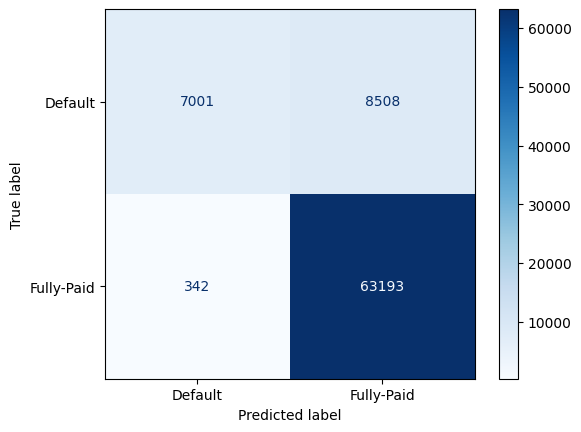

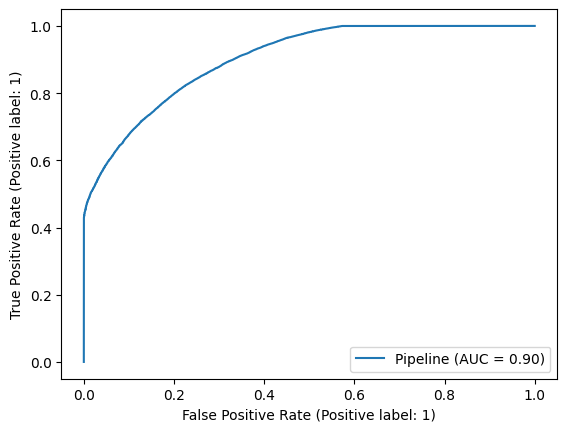

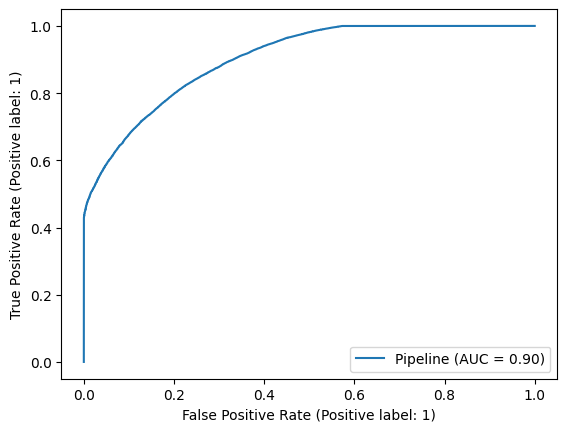

In [20]:
disp = ConfusionMatrixDisplay.from_estimator(
    clf, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)

display = RocCurveDisplay.from_estimator(clf, X_test, y_test)
display.plot()

# ✔️ Register the Model with Model Registry

In [21]:
mr = proj.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


In [22]:
import joblib
import os
os.makedirs("lending_model/features", exist_ok=True)
plt.savefig('lending_model/roc_curve.png')
joblib.dump(clf, 'lending_model/lending_model.pkl')

accuracy = roc_auc_score(y_test, clf.predict(X_test))

<Figure size 640x480 with 0 Axes>

In [23]:
accuracy

0.7230162236999622

In [24]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(X_test)
output_schema = Schema(y_test)

fraud_model = mr.sklearn.create_model("lending_model",
                                      metrics={'accuracy': accuracy},
                                      input_example=X_test.sample().to_numpy(), 
                                      model_schema=ModelSchema(input_schema=input_schema, output_schema=output_schema))
fraud_model.save('lending_model')

  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/398/models/lending_model/3


Model(name: 'lending_model', version: 3)